# Time-Dependent SIR Model

Adapted from https://arxiv.org/abs/2003.00122

Shoutout to Ping-En Lu and team for providing source code

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 300)

from datetime import timedelta
import math

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi']= 600
sns.set()

from sklearn.model_selection import GridSearchCV

In [2]:
# Helper functions
def clean_df(df_metric, country='US', metric='Confirmed', start_date = '2020-01-22'):
    dropCols = ['Province/State', 'Country/Region','Lat','Long']
    df = df_metric[df_metric['Country/Region'] == country].drop(dropCols,axis=1).T.reset_index()
    df.columns = ['Date',metric]
    df['Date'] = pd.to_datetime(df.Date).dt.date
    
    df['EpidemicStartDate'] = df.sort_values(by='Date').loc[df[metric]!=0].Date.iloc[0]
    df['DaysElapsed'] = (df.Date - df.EpidemicStartDate).dt.days + 1

    return df[['Date','DaysElapsed',metric]].loc[df.Date >= pd.to_datetime(start_date)]

def data_split(data, orders, start):
    x_train = np.empty((len(data) - start - orders, orders))
    y_train = data[start + orders:]

    for i in range(len(data) - start - orders):
        x_train[i] = data[i + start:start + orders + i]
        
    return x_train, y_train

In [3]:
# Read in data from Johns Hopkins CSSE for US
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
deaths_df    = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

start_date   = '2020-03-01'
X_cml        = np.array(clean_df(confirmed_df, 'US', 'Confirmed', start_date).Confirmed, dtype=np.float64)
recovered    = np.array(clean_df(recovered_df, 'US', 'Recovered', start_date).Recovered, dtype=np.float64)
death        = np.array(clean_df(deaths_df,    'US', 'Deaths',    start_date).Deaths,    dtype=np.float64)

population   = 329500000

In [4]:
# Preprocessing
X = X_cml - recovered - death
R = recovered + death

n = np.array([population] * len(X), dtype=np.float64)

S = n - X - R

gamma = np.diff(R) / X[:-1]
beta = (np.diff(X) + np.diff(R))/X[:-1]
R0 = beta / gamma

print("The latest transmission rate (beta) of SIR model:", beta[-1])
print("The latest recovering rate (gamma) of SIR model:", gamma[-1])
print("The latest basic reproduction number R0:", round(R0[-1],3))

The latest transmission rate (beta) of SIR model: 0.08286889902200113
The latest recovering rate (gamma) of SIR model: 0.009298921693560357
The latest basic reproduction number R0: 8.912


In [8]:
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.linear_model import Ridge

# Orders of the two FIR filters
orders_beta = 3
orders_gamma = 3

# Starting day for the data training
start_beta = len(beta) - 21
start_gamma = len(beta) - 28

# Create a feature set consisting of previous three Y observations as X1, X2, and X3
x_beta, y_beta = data_split(beta, orders_beta, start_beta)
x_gamma, y_gamma = data_split(gamma, orders_gamma, start_gamma)

# Train and test using KNN regression
clf_beta  = KNN(n_neighbors=4, weights='uniform').fit(x_beta, y_beta)
clf_gamma = KNN(n_neighbors=14, weights='uniform').fit(x_gamma, y_gamma)

# Train and test using Ridge regression
# clf_beta  = Ridge(alpha=0.003255, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_beta, y_beta)
# clf_gamma = Ridge(alpha=0.001675, copy_X=True, fit_intercept=False, max_iter=None, normalize=True, random_state=None, solver='auto', tol=1e-08).fit(x_gamma, y_gamma)


beta_hat = clf_beta.predict(x_beta)
gamma_hat = clf_gamma.predict(x_gamma)

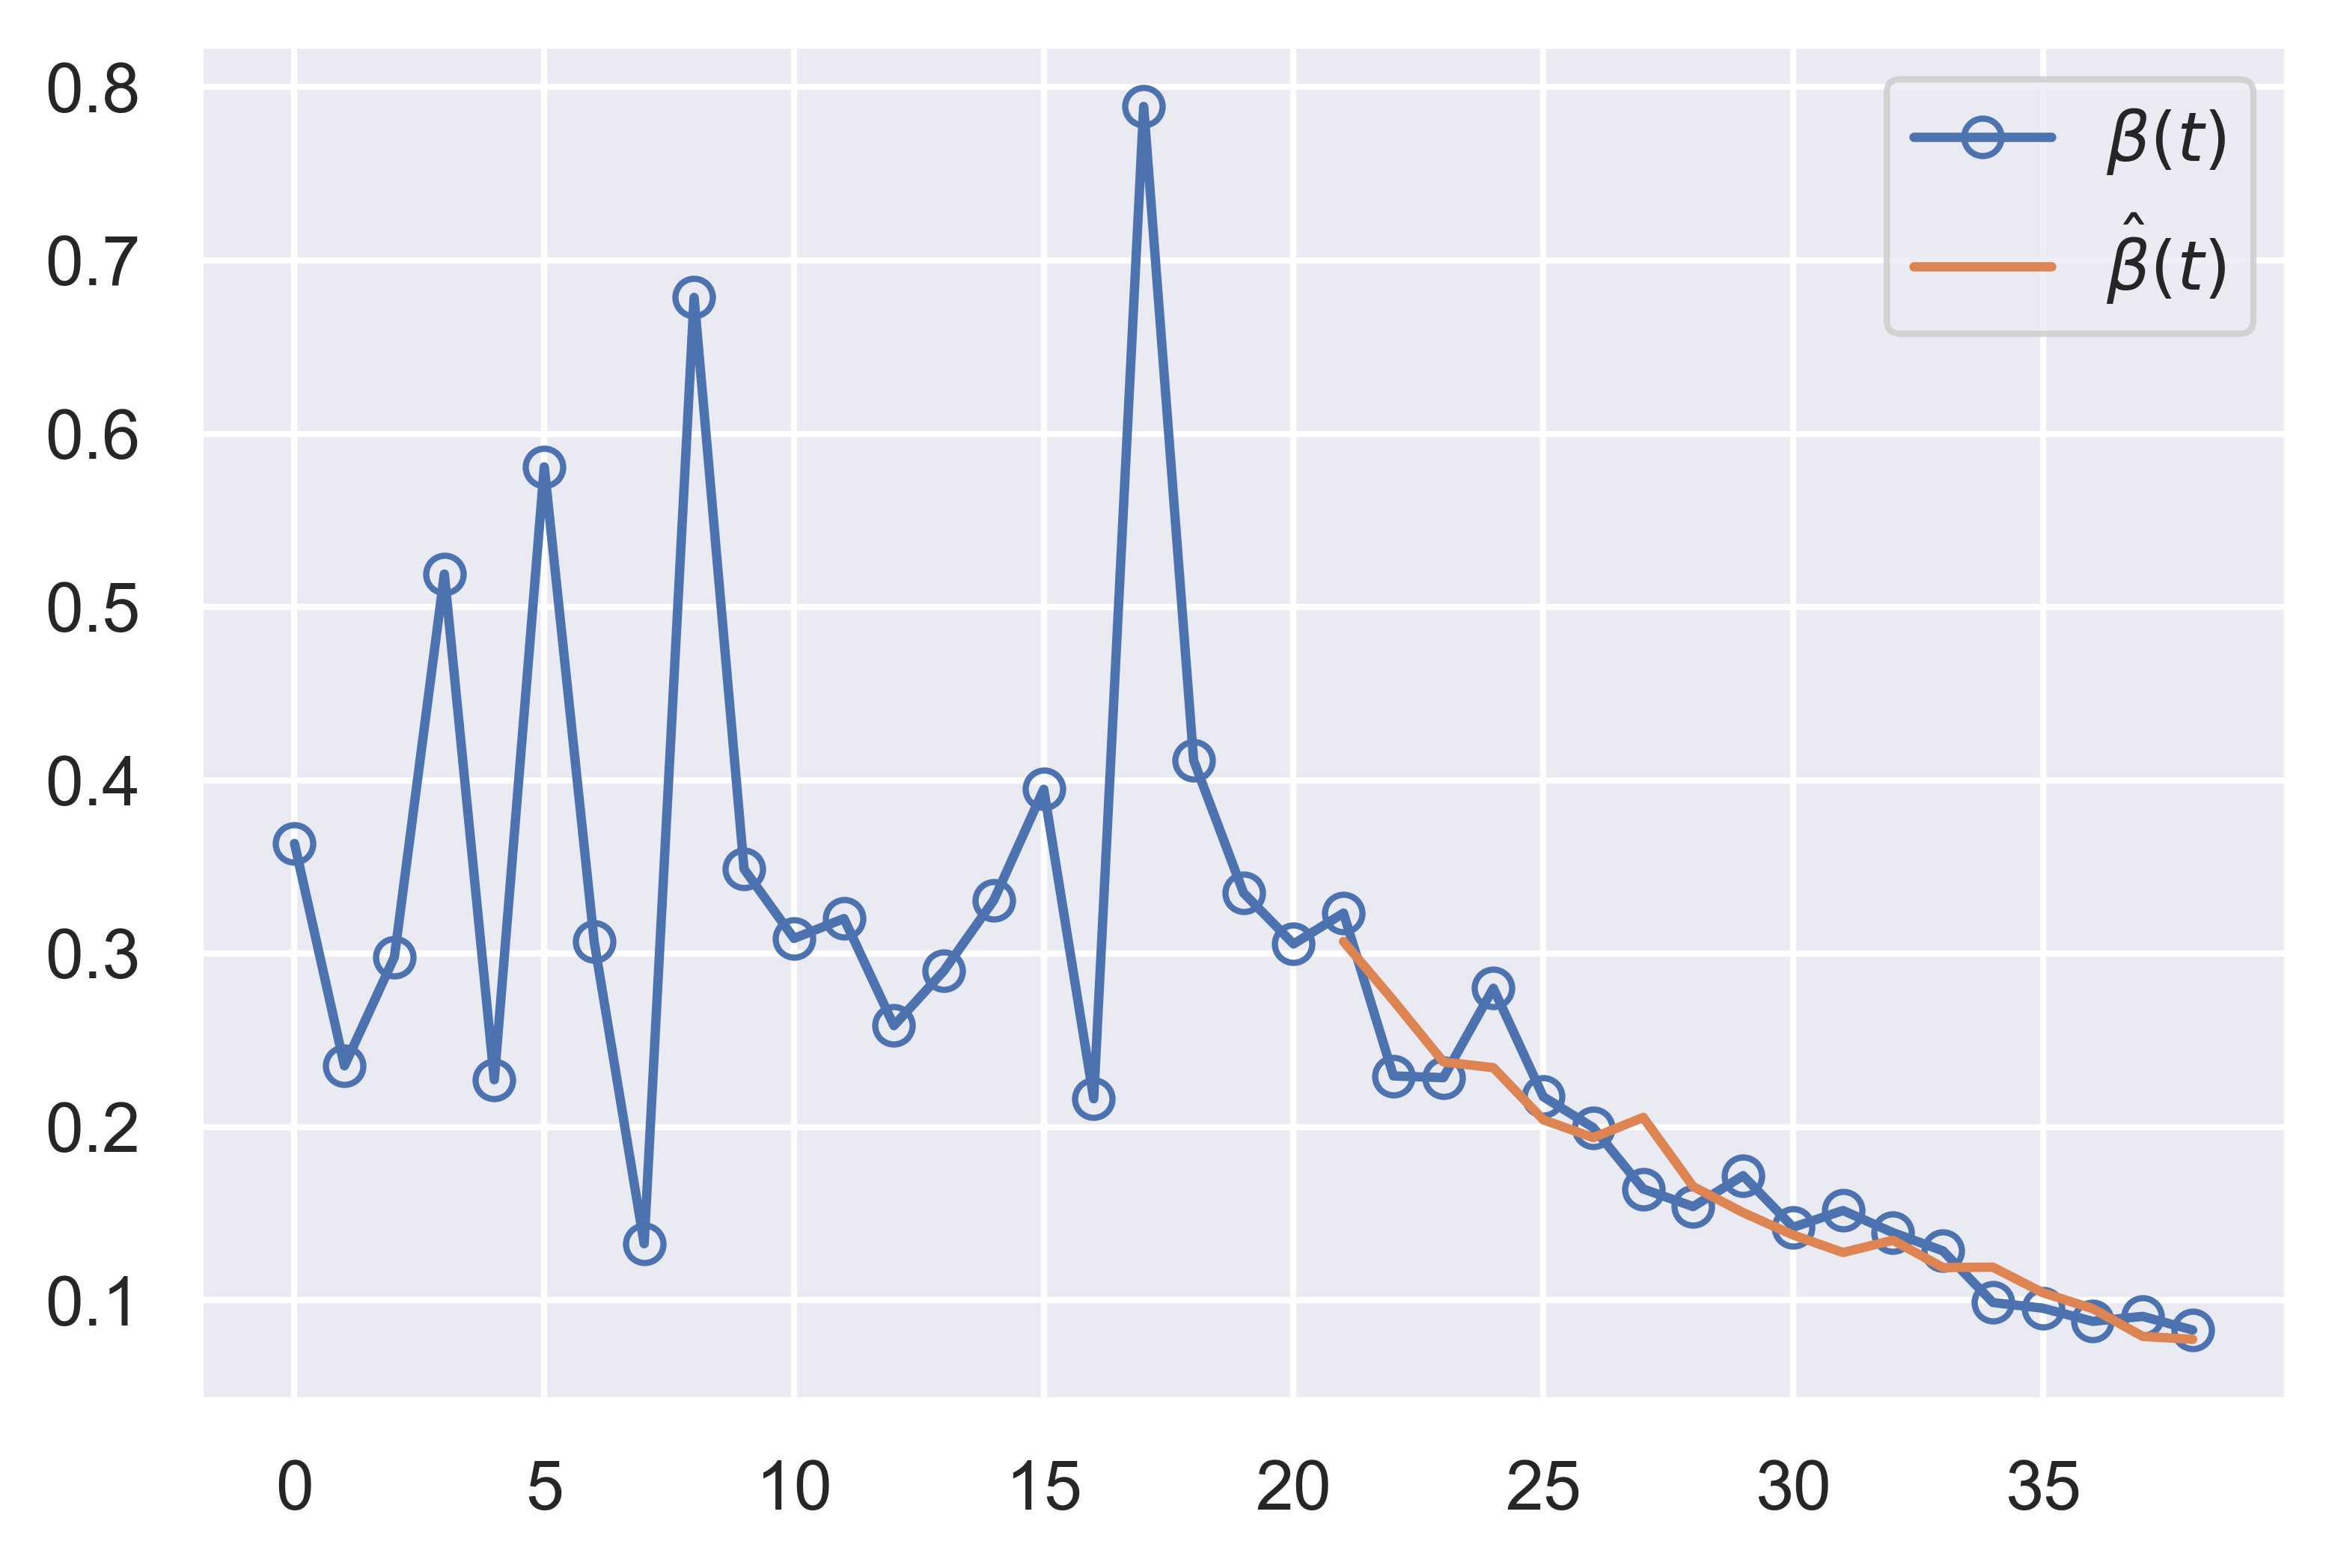

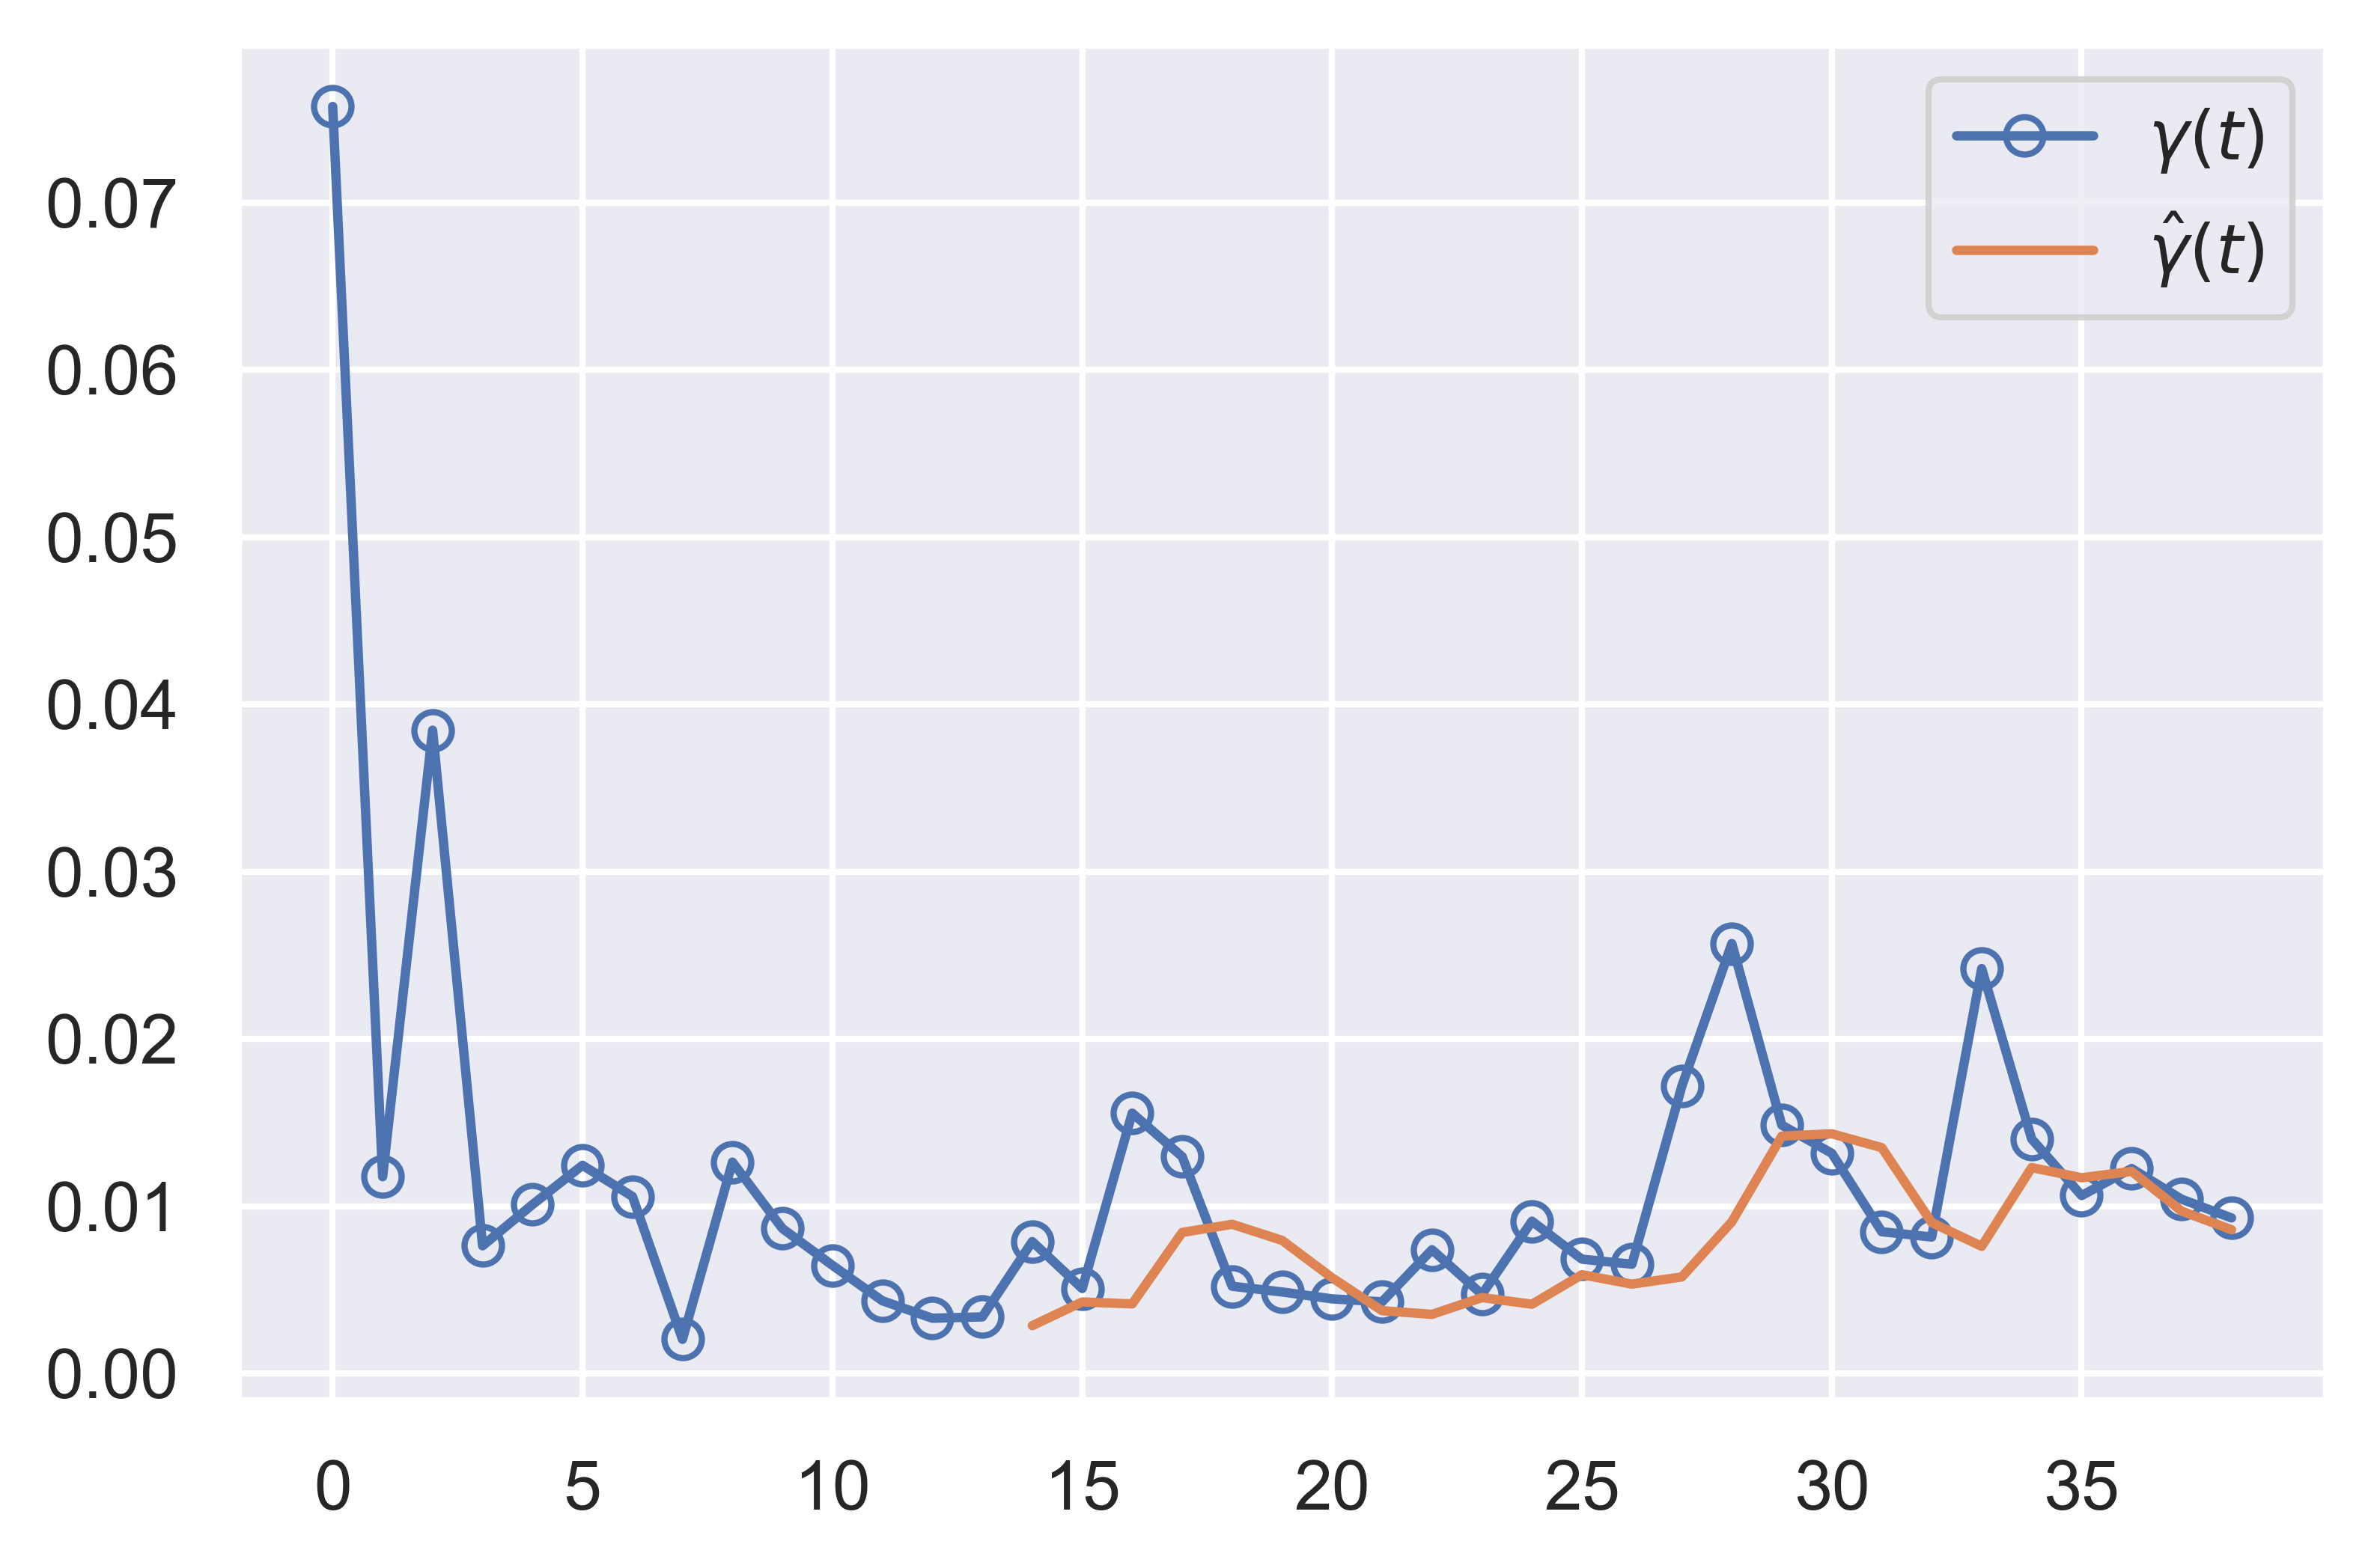

In [9]:
# Plot actual vs. predicted transmission and recovery rates

plt.figure(1)
plt.plot(beta, 'o-', markerfacecolor='none', label=r'$\beta (t)$')
plt.plot(np.arange(len(beta)-len(beta_hat), len(beta)), beta_hat, label=r'$\hat{\beta}(t)$')
plt.legend()

plt.figure(2)
plt.plot(gamma, 'o-', markerfacecolor='none', label=r'$\gamma (t)$')
plt.plot(np.arange(len(gamma)-len(gamma_hat), len(gamma)), gamma_hat, label=r'$\hat{\gamma}(t)$')
plt.legend()

plt.show()

## Time Dependent Discrete SIR Model

In [102]:
##### Parameters for the Time-dependent SIR model #####
stop_X = 0 # stopping criteria
stop_day = 180 # maximum iteration days (W in the paper)

day_count = 0
turning_point = 0

S_predict = [S[-1]]
X_predict = [X[-1]]
R_predict = [R[-1]]

predict_beta= beta[-orders_beta:].tolist()
predict_gamma = gamma[-orders_gamma:].tolist()

while (X_predict[-1] >= stop_X) and (day_count <= stop_day):
    if predict_beta[-1] > predict_gamma[-1]:
        turning_point += 1
    
    next_beta = clf_beta.predict(np.asarray([predict_beta[-orders_beta:]]))[0]
    next_gamma = clf_gamma.predict(np.asarray([predict_gamma[-orders_gamma:]]))[0]

    next_beta = max(next_beta,0)
    next_gamma = max(next_gamma,0)
#     next_gamma = max(next_gamma, 1./22)
    
    predict_beta.append(next_beta)
    predict_gamma.append(next_gamma)

    next_S = ((-predict_beta[-1] * S_predict[-1] *
               X_predict[-1]) / n[-1]) + S_predict[-1]
    next_X = ((predict_beta[-1] * S_predict[-1] * X_predict[-1]) /
              n[-1]) - (predict_gamma[-1] * X_predict[-1]) + X_predict[-1]
    next_R = (predict_gamma[-1] * X_predict[-1]) + R_predict[-1]

    S_predict.append(next_S)
    X_predict.append(next_X)
    R_predict.append(next_R)

    day_count += 1

In [109]:
# Shows progression of predicted reproduction rate (Should be <1 to converge to DFE)
r0_pred = pd.DataFrame({'gamma':predict_gamma, 'beta':predict_beta})
r0_pred['r0'] = r0_pred.beta / r0_pred.gamma
r0_pred

,gamma,beta,r0
0,0.012254,0.087885,7.172046
1,0.010419,0.090754,8.710268
2,0.009299,0.082869,8.911668
3,0.009967,0.087169,8.745720
4,0.011431,0.087169,7.625916
5,0.011455,0.087169,7.609682
6,0.011465,0.087169,7.602749
7,0.010691,0.087169,8.153324
8,0.011465,0.087169,7.602749
9,0.010691,0.087169,8.153324


In [104]:
########## Print Info ##########
print('\nConfirmed cases tomorrow:', np.rint(X_predict[1] + R_predict[1]))
print('Infected persons tomorrow:', np.rint(X_predict[1]))
print('Recovered + Dead persons tomorrow:', np.rint(R_predict[1]))

print('\nEnd day:', day_count)
print('Confirmed cases on the end day:', np.rint(X_predict[-2] + R_predict[-2]))

print('\nTurning point:', turning_point)


Confirmed cases tomorrow: 497958.0
Infected persons tomorrow: 451888.0
Recovered + Dead persons tomorrow: 46070.0

End day: 181
Confirmed cases on the end day: 327137662.0

Turning point: 181


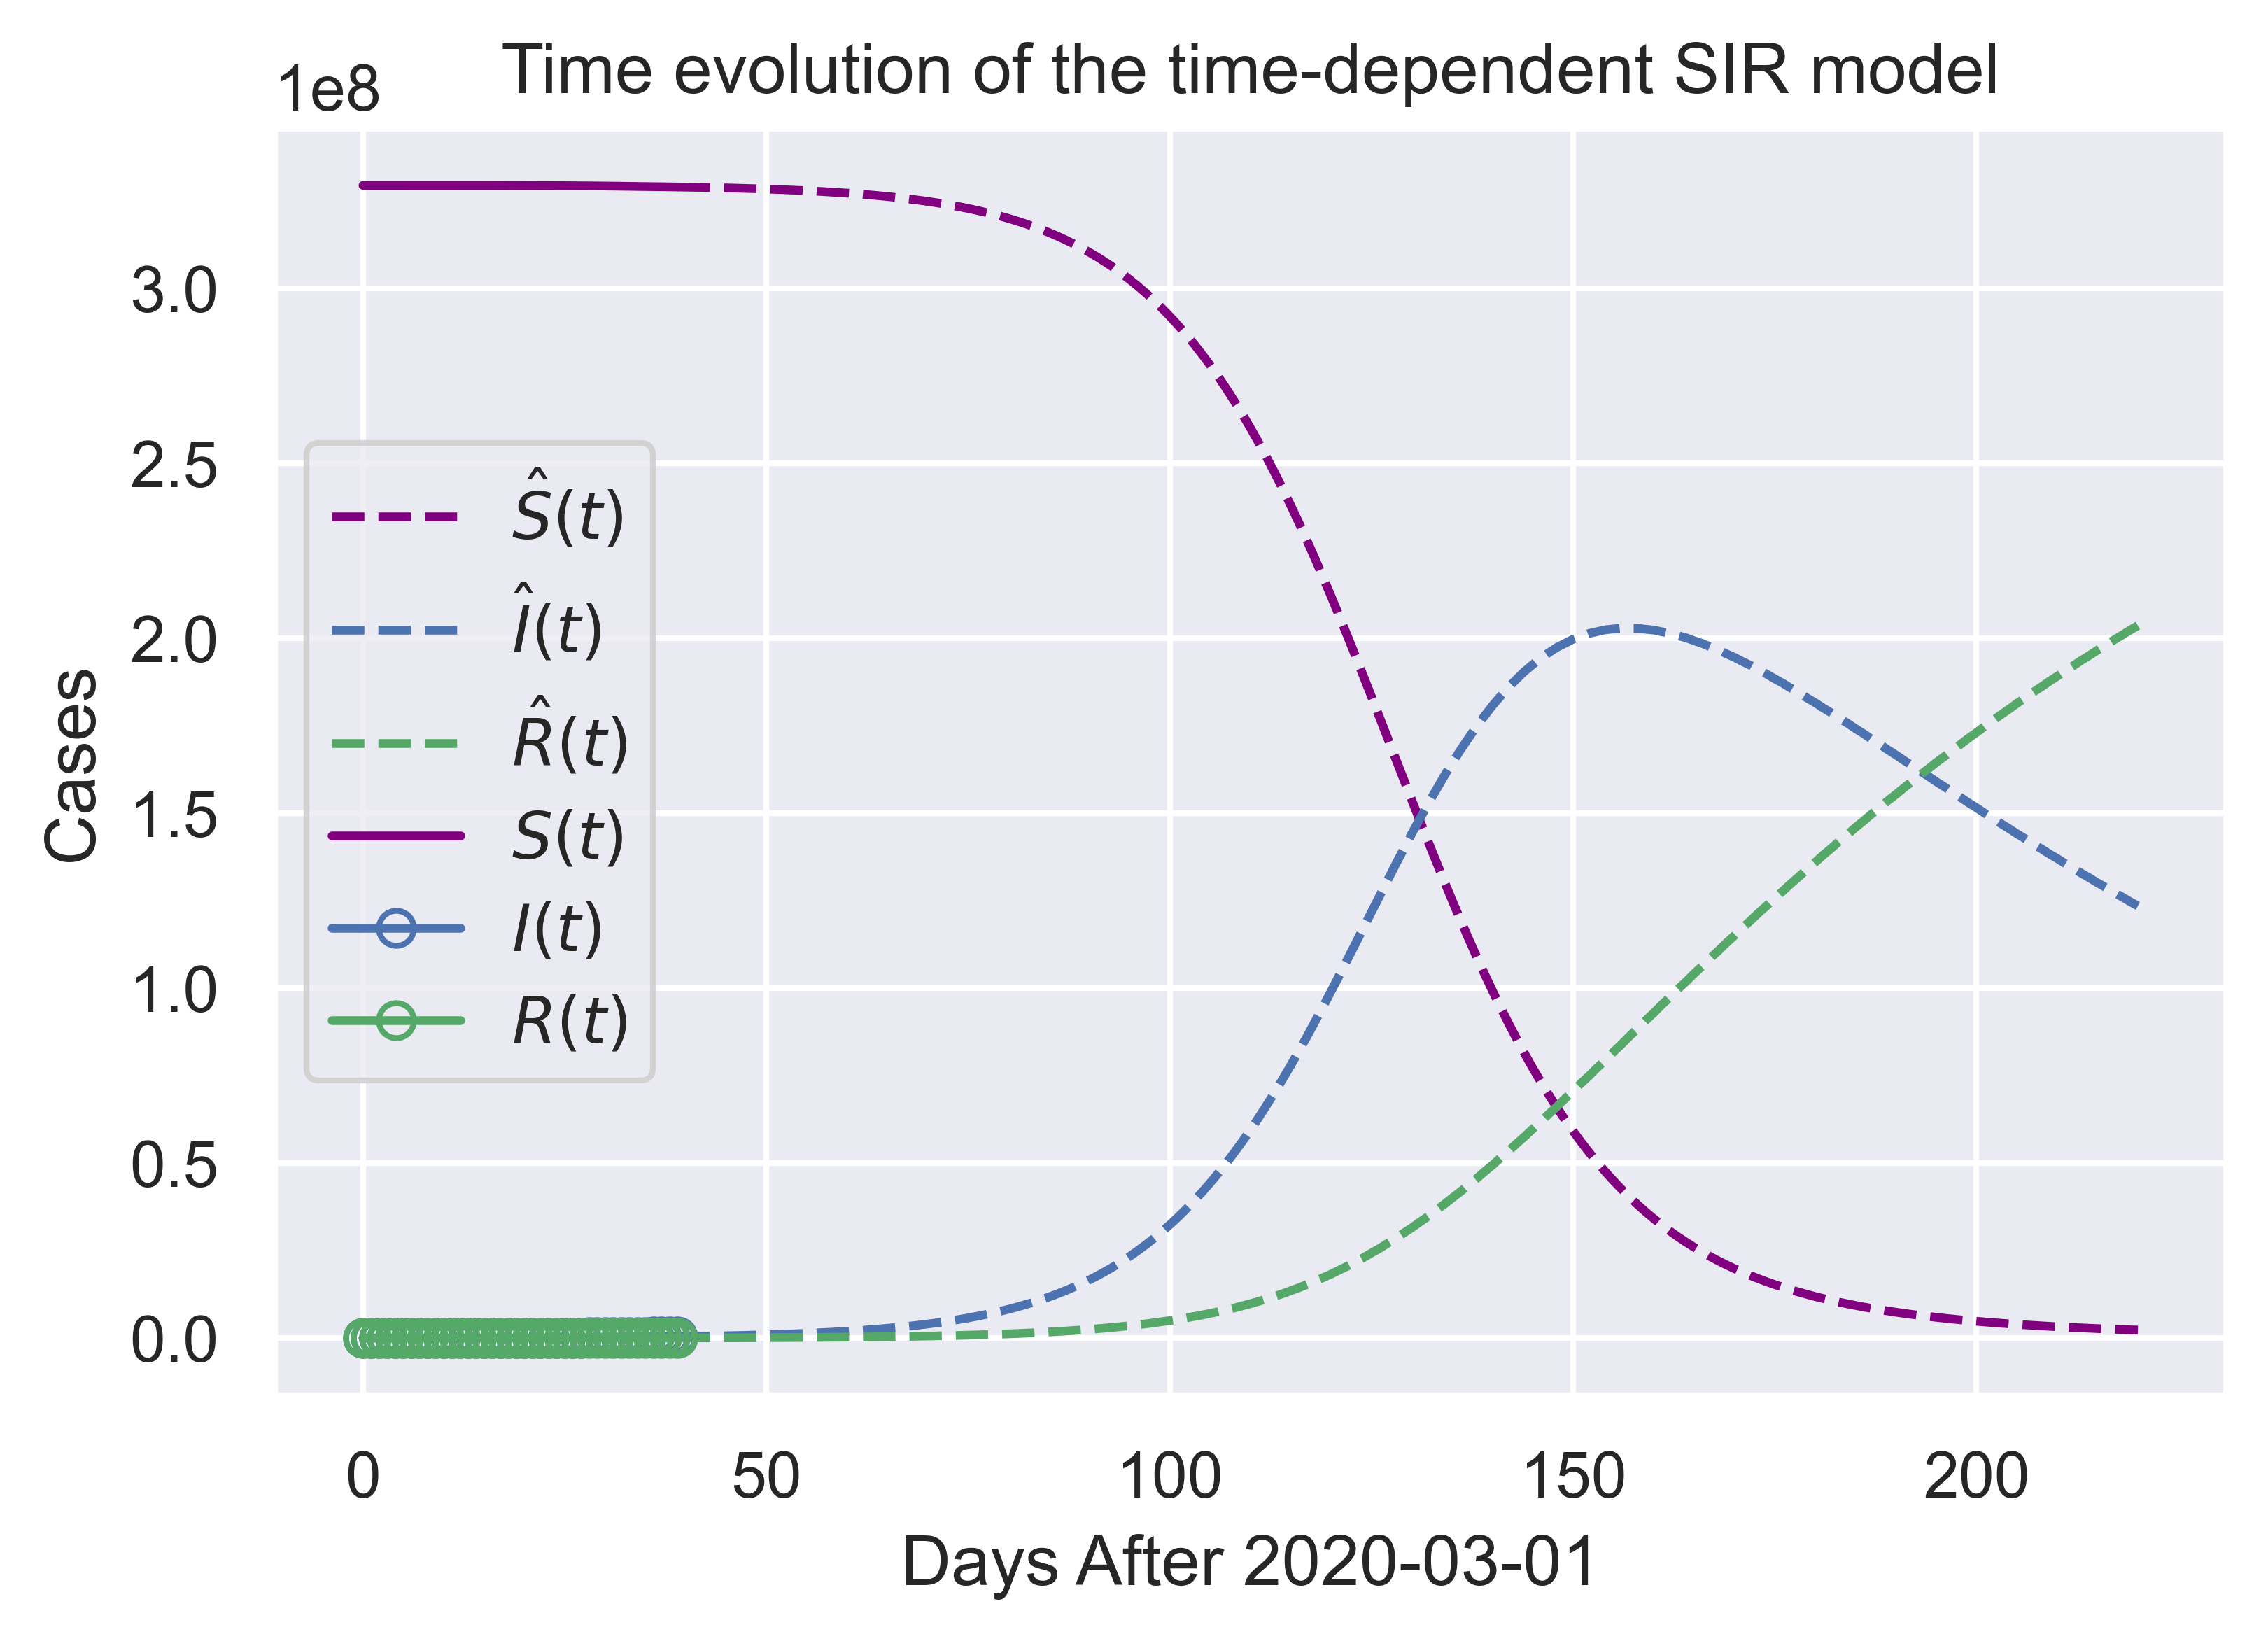

In [120]:
########## Plot the time evolution of the time-dependent SIR model ##########
# plt.figure(3)

plt.plot(range(len(S) - 1, len(S) - 1 + len(S_predict)), S_predict, '--', label=r'$\hat{S}(t)$', color='purple')
plt.plot(range(len(X) - 1, len(X) - 1 + len(X_predict)), X_predict, '--', label=r'$\hat{I}(t)$', color='b')
plt.plot(range(len(R) - 1, len(R) - 1 + len(R_predict)), R_predict, '--', label=r'$\hat{R}(t)$', color='g')

plt.plot(range(len(S)), S, '-',  label=r'$S(t)$', markerfacecolor = 'none', color='purple')
plt.plot(range(len(X)), X, 'o-', label=r'$I(t)$', markerfacecolor = 'none', color='b')
plt.plot(range(len(R)), R, 'o-', label=r'$R(t)$', markerfacecolor = 'none', color='g')


plt.xlabel('Days After {}'.format(start_date))
plt.ylabel('Cases')
plt.title('Time evolution of the time-dependent SIR model')
plt.legend()

plt.show()